# Initialization

In [310]:
from src.SIV_library.lib import SIV, OpticalFlow
from src.SIV_library.plots import plot_flow
from src.SIV_library.advanced import ctf_optical, match_refine, Warp
from torchPIV import OfflinePIV

import os
import sys
import torch
import matplotlib.pyplot as plt

plt.rcParams["animation.html"] = "jshtml"
%matplotlib notebook
# %matplotlib inline

os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
sys.path.append("../../")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [341]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device:', device)

if device == "cuda":
    torch.cuda.empty_cache()
    
folder = "../Test Data/ellende"

device: cuda


In [357]:
plt.close('all')

In [313]:
xscale = 50/30  # px / mm
yscale = 25/30
fps = 240

factorx = fps/(xscale * 1000)
factory = fps/(yscale * 1000)

# TorchPIV

In [98]:
piv_gen = OfflinePIV(
    folder=folder, # Path to experiment
    device=torch.cuda.get_device_name(), # Device name
    file_fmt="tif",
    wind_size=64,
    overlap=32,
    dt=12, # Time between frames, mcs
    scale = 0.02, # mm/pix
    multipass=2,
    multipass_mode="DWS", # CWS or DWS
    multipass_scale=2.0, # Window downscale on each pass
    folder_mode="sequential" # Pairs or sequential frames 
)

for out in piv_gen():
    x, y, vx, vy = out
    x, y = x/piv_gen._scale, y/piv_gen._scale

Load time 0.005 sec Iteration finished in 0.049 sec Warning! to many false vectors
Warning! to many false vectors
Batch finished in 0.073 sec


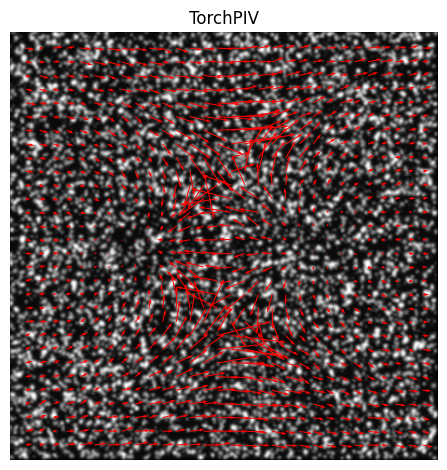

In [99]:
# plt.close('all')

fig, ax = plt.subplots(1, 1)
 
frame = piv_gen._dataset[0][0]
ax.imshow(frame, cmap='gray')
ax.quiver(x, y, vx, -vy, color='red', scale=0.05, scale_units='xy', angles='xy')

ax.set_title(f'TorchPIV')
ax.set_axis_off()

fig.tight_layout()
plt.show()

# Matching

In [350]:
mode = 1

t = SIV(
    folder=folder, 
    device=device, 
    window_size=64, 
    overlap=48, 
    search_area=(10, 0, 5, 5), 
    mode=mode, 
    num_passes=1, 
    scale_factor=0.5
)

In [351]:
x0, y0, u0, v0 = t.run()

SAD: 100%|██████████| 35/35 [00:08<00:00,  4.27it/s]


In [352]:
plt.close('all')

idx = 2
fig, ax = plt.subplots(1, 1)

x0, y0, u0, v0 = x0.cpu(), y0.cpu(), u0.cpu(), v0.cpu()
 
frame = t.dataset[idx][0].cpu().numpy()
ax.imshow(frame, cmap='gray')
ax.quiver(x0[idx].numpy(), y0[idx].numpy(), u0[idx].numpy(), -v0[idx].numpy(), color='red', scale=1., scale_units='xy', angles='xy')

ax.set_title(f'Template Matching - {"SAD" if mode == 1 else "Correlation"}')
ax.set_axis_off()

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

Interpolate velocity field:

In [356]:
w = Warp(x0, y0, u0, v0)
w.interpolate_field(t.dataset.img_shape)
x1, y1, u1, v1 = w.x, w.y, w.u, w.v

In [358]:
res = -torch.mean(u1[::2, 175:225, 65:] * factorx, dim=(1, 2)).cpu().numpy()
plt.plot(res)
plt.show()

<IPython.core.display.Javascript object>

In [285]:
# plt.close('all')
_ = plot_flow(u1 * factorx, v1 * factory, grid_spacing=32, fn=None)

<IPython.core.display.Javascript object>

# Optical flow

In [143]:
u = OpticalFlow(
    folder=folder, 
    device=device, 
    alpha=100., 
    num_iter=1000, 
    eps=0.
)

In [144]:
x2, y2, u2, v2 = u.run()

Optical flow: 100%|██████████| 1/1 [00:12<00:00, 12.54s/it]


In [146]:
# plt.close('all')
_ = plot_flow(u2, v2, grid_spacing=32, fn=None)

<IPython.core.display.Javascript object>

Course-to-fine optical flow:

In [149]:
x3, y3, u3, v3 = ctf_optical(u, num_passes=3, scale_factor=1/2)

Optical flow: 100%|██████████| 1/1 [00:12<00:00, 12.24s/it]


In [150]:
# plt.close('all')
_ = plot_flow(u3, v3, grid_spacing=32, fn=None)

<IPython.core.display.Javascript object>

# Hybrid method (matching + optical flow)

In [151]:
x4, y4, u4, v4 = match_refine(t, u)

Optical flow: 100%|██████████| 1/1 [00:12<00:00, 12.18s/it]


In [142]:
# plt.close('all')
_ = plot_flow(u4, v4, grid_spacing=32)  # , fn="../experiments/hybrid.gif")

<IPython.core.display.Javascript object>